**Necessary imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics

**Downloading and preparing the dataset**


In [ ]:
# list containing first 11 column names, remaining 45 columns contain one-hot encodec values which represent "Wilderness
# Area" (4 columns), "Soil Type" (40 columns) and target column "Cover Type"
attributes = ["Elevation", "Aspect", "Slope", "Horizontal Distance To Hydrology", "Vertical Distance To Hydrology", "Horizontal Distance To Roadways", "Hillshade 9am",
              "Hillshade Noon", "Hillshade 3pm","Horizontal Distance To Fire Points"]

import gzip
from zipfile import ZipFile
!wget http://archive.ics.uci.edu/static/public/31/covertype.zip
# additional information about the dataset can be found on http://archive.ics.uci.edu/dataset/31/covertype

with ZipFile('/content/covertype.zip') as datazip:
    datazip.extract('covtype.data.gz')
    with gzip.open('/content/covtype.data.gz') as datacsv:
      data = pd.read_csv(datacsv, header=0, names=attributes + list(str(x) for x in range(10, 54)) + ["Cover Type"])

print(data.head)

--2023-11-11 17:28:03--  http://archive.ics.uci.edu/static/public/31/covertype.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘covertype.zip’

covertype.zip           [   <=>              ]  10.73M  2.30MB/s    in 7.5s    

2023-11-11 17:28:11 (1.42 MB/s) - ‘covertype.zip’ saved [11251206]

<bound method NDFrame.head of         Elevation  Aspect  Slope  Horizontal Distance To Hydrology  \
0            2590      56      2                               212   
1            2804     139      9                               268   
2            2785     155     18                               242   
3            2595      45      2                               153   
4            2579     132      6                               300   
...           ...     ...    ...                               .

**Exploratory data analysis**

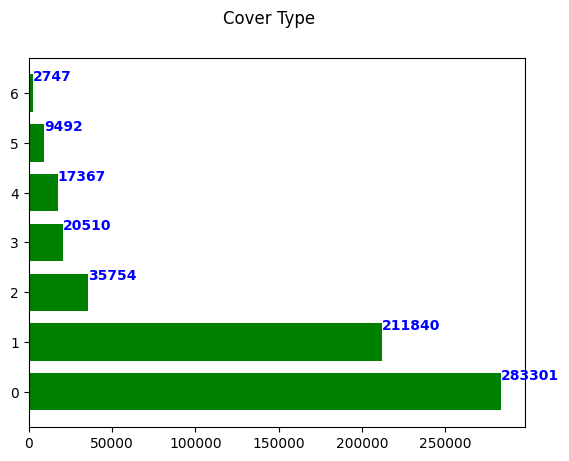

In [ ]:
y = data["Cover Type"].value_counts()
fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color = "green")
fig.suptitle('Cover Type', fontsize=12)
for i, v in enumerate(y):
  ax.text(v + 3, i + .25, str(v), color = "blue", fontweight = "bold")
plt.show()

There is a class imbalance as some cover types are underrepresented

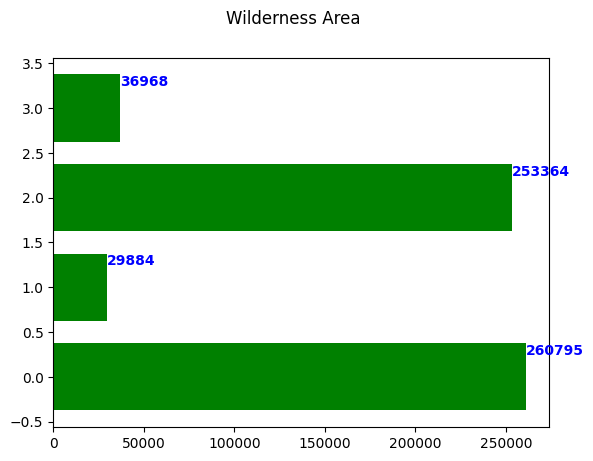

In [ ]:
y = data.iloc[:, 10:14].sum(axis=0)
fig, ax = plt.subplots()
width = 0.75
ind = np.arange(len(y))
ax.barh(ind, y, width, color = "green")
fig.suptitle('Wilderness Area', fontsize=12)
for i, v in enumerate(y):
  ax.text(v + 3, i + .25, str(v), color = "blue", fontweight = "bold")
plt.show()

Types of Wilderness Areas are also imbalanced. It may be related to the imbalance of the target.

**Data normalization and target encoding**


In [ ]:
normalized = pd.DataFrame(preprocessing.normalize(data.iloc[:, :10].values), columns=attributes)

temp = data.iloc[:, 10:14]
x, y = temp.shape
for i in temp:
  temp = temp.replace({i : {1 : temp[i].sum() / x}})
normalized['Wilderness Area'] = temp.sum(axis = 1)

temp = data.iloc[:, 14:54]
for i in temp:
  temp = temp.replace({i : {1 : temp[i].sum() / x}})
normalized['Soil Type'] = temp.sum(axis = 1)

**Oversampling using SMOTE**

In [ ]:
x = np.array(normalized.iloc[:, :11])
y = np.array(data["Cover Type"])

smote = SMOTE()
x, y = smote.fit_resample(x, y)

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=0.1)

**RandomForest**

In [ ]:
model = RandomForestClassifier()

model.fit(x_train, y_train)
predicted = model.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

              precision    recall  f1-score   support

           1     0.9720    0.9689    0.9704     28337
           2     0.9724    0.9602    0.9663     28260
           3     0.9950    0.9975    0.9962     28330
           4     0.9984    1.0000    0.9992     28454
           5     0.9945    0.9997    0.9971     28162
           6     0.9951    0.9987    0.9969     28488
           7     0.9969    0.9998    0.9983     28280

    accuracy                         0.9892    198311
   macro avg     0.9892    0.9892    0.9892    198311
weighted avg     0.9892    0.9892    0.9892    198311



**RandomForest with hyperparameter tunining**

In [ ]:
model_grid = {'max_depth': [100],
              'min_samples_split': [5, 10],
              'min_samples_leaf': [2, 4],}

model = RandomForestClassifier()
model_search = GridSearchCV(estimator=model, param_grid=model_grid, cv=3, verbose=3, n_jobs=2)

model_search.fit(x_train, y_train)
predicted = model_search.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


              precision    recall  f1-score   support

           1     0.9704    0.9639    0.9671     28245
           2     0.9677    0.9565    0.9621     28372
           3     0.9942    0.9961    0.9952     28132
           4     0.9977    1.0000    0.9989     28371
           5     0.9945    0.9998    0.9972     28443
           6     0.9933    0.9986    0.9959     28461
           7     0.9964    0.9998    0.9981     28287

    accuracy                         0.9878    198311
   macro avg     0.9877    0.9878    0.9878    198311
weighted avg     0.9877    0.9878    0.9878    198311



**KNeighborsClassifier**

In [ ]:
model = KNeighborsClassifier()

model.fit(x_train, y_train)
predicted = model.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

              precision    recall  f1-score   support

           1     0.9642    0.9704    0.9673     28337
           2     0.9804    0.9403    0.9599     28260
           3     0.9935    0.9980    0.9957     28330
           4     0.9989    0.9998    0.9994     28454
           5     0.9863    0.9999    0.9931     28162
           6     0.9929    0.9992    0.9960     28488
           7     0.9912    0.9998    0.9955     28280

    accuracy                         0.9868    198311
   macro avg     0.9868    0.9868    0.9867    198311
weighted avg     0.9868    0.9868    0.9867    198311



**KNeighborsClassifier with hyperparameter tunining**

In [ ]:
model_grid = {'n_neighbors' : [int(x) for x in np.linspace(start = 5, stop = 30, num = 5)],
               'weights' : ['uniform', 'distance'],
               'leaf_size' : [int(x) for x in np.linspace(start = 30, stop = 100, num = 10)],
               'metric' : ['minkowski', 'manhattan']}

model = KNeighborsClassifier()
model_random = RandomizedSearchCV(estimator=model, param_distributions=model_grid, n_iter=10, cv=3, verbose=2, n_jobs=-1)

model_random.fit(x_train, y_train)
predicted = model_random.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
              precision    recall  f1-score   support

           1     0.9642    0.9704    0.9673     28337
           2     0.9804    0.9403    0.9599     28260
           3     0.9935    0.9980    0.9957     28330
           4     0.9989    0.9998    0.9994     28454
           5     0.9863    0.9999    0.9931     28162
           6     0.9929    0.9992    0.9960     28488
           7     0.9912    0.9998    0.9955     28280

    accuracy                         0.9868    198311
   macro avg     0.9868    0.9868    0.9867    198311
weighted avg     0.9868    0.9868    0.9867    198311



**Gaussian Naive Bayes**

In [ ]:
model = GaussianNB()

model.fit(x_train, y_train)
predicted = model.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

              precision    recall  f1-score   support

           1     0.3993    0.3236    0.3575     28337
           2     0.4998    0.1093    0.1794     28260
           3     0.3053    0.0514    0.0880     28330
           4     0.4630    1.0000    0.6329     28454
           5     0.3309    0.8703    0.4795     28162
           6     0.2343    0.0588    0.0940     28488
           7     0.5519    0.4239    0.4795     28280

    accuracy                         0.4051    198311
   macro avg     0.3978    0.4053    0.3301    198311
weighted avg     0.3977    0.4051    0.3300    198311



**Gaussian Naive Bayes with hyperparameter tunining**

In [ ]:
model_grid = {'var_smoothing': np.logspace(0, -9, num=100)}

model = GaussianNB()
model_random = GridSearchCV(estimator=model, param_grid=model_grid, verbose=2, n_jobs=-1, scoring='accuracy')

model_random.fit(x_train, y_train)
predicted = model_random.predict(x_test)
print(metrics.classification_report(y_test, predicted, digits=4))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
              precision    recall  f1-score   support

           1     0.4093    0.2895    0.3391     28337
           2     0.5192    0.1215    0.1970     28260
           3     0.4979    0.1586    0.2406     28330
           4     0.5251    0.9951    0.6874     28454
           5     0.3203    0.8888    0.4709     28162
           6     0.2998    0.1044    0.1548     28488
           7     0.5666    0.4136    0.4781     28280

    accuracy                         0.4243    198311
   macro avg     0.4483    0.4245    0.3669    198311
weighted avg     0.4483    0.4243    0.3668    198311

